# PySDMs Coast redwoods Modeling


---

Author: [Daniel Furman](mailto:dryanfurman@gmail.com)

Analyses included within were conducted for the DAT/Arathon 2021 Fellowship

In [5]:
from PySDMs import PySDMs
import numpy as np
import pandas as pd
import re
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from pycaret import classification as pycaret, internal


test % of total data:  0.23395958879829848
The RandomState seed for this run is 192

     > et
     > ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=192, verbose=0,
                     warm_start=False)
Training features / target shape:

     > (2161, 19) (2161,)


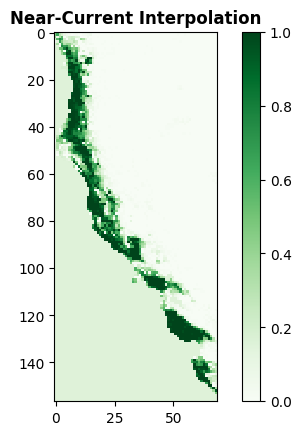

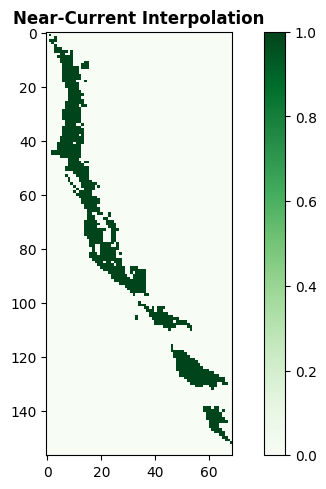

FileNotFoundError: [Errno 2] No such file or directory: 'test/outputs/probability_1.tif' -> 'test/outputs/probability_192.tif'

In [11]:
# Run PySDMs object over the random seed(s)
species_code = 'cr'

for seed in [192,]:   
    
    # Data IO
    tif_input_dir = 'test/data/train-rasters/bclim*.tif'
    df_input_dir = 'test/data/env_train/env_train_'+species_code+'_'
    mod_list = ['et', 'xgboost', 'catboost']
    
    col_names = ['pa','bclim7', 'bclim4', 'bclim3', 'bclim2', 'bclim5', 'bclim6',
       'bclim11', 'bclim8', 'bclim9', 'bclim10', 'bclim15', 'bclim13',
       'bclim19', 'bclim16', 'bclim12', 'bclim17', 'bclim1', 'bclim18']
    
    if os.path.exists('test/data/env_train/env_train_'+species_code+'_' + str(seed) + '_metadata.csv'):
        data = pd.read_csv('test/data/env_train/env_train_'+species_code+'_' + str(seed) + '_metadata.csv')
        exp_name = species_code+'_'+str(seed)
        #take 2/6 blockCV folds for test set
        train_data = data[(data['fold']!=5) | (data['fold']!=6)][col_names]
        test_data = data[(data['fold']==5) | (data['fold']==6)][col_names]
        print()
        print('test % of total data: ', len(test_data['pa'])/(len(train_data['pa'])+len(test_data['pa'])))
    
        # Initialize class 
        coastal_redwoods = PySDMs(train_data, test_data, seed, target='pa',
            exp_name=species_code+'_'+str(seed), normalize=False, metric='AUC',
            silent=True, mod_list=mod_list)
        
        # Model Fitting with self.fit()
        learner = coastal_redwoods.fit()
        pd.Series(pycaret.get_config('X_train').columns).to_csv('test/outputs/features_'+str(seed)+'.csv')
    
        # Geo-classification with self.interpolate()
        coastal_redwoods.interpolate(tif_input_dir, df_input_dir, 'outputs/')
        os.rename('test/outputs/probability_1.tif', 'test/outputs/probability_'+str(seed)+'.tif')
        os.rename('test/outputs/responses.tif', 'test/outputs/responses_'+str(seed)+'.tif')

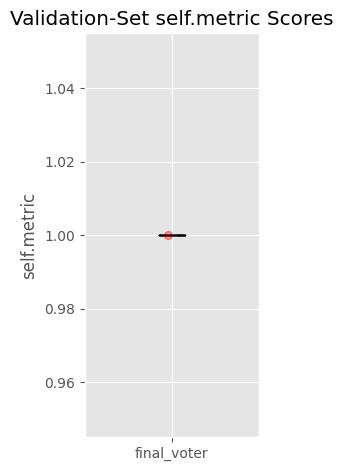

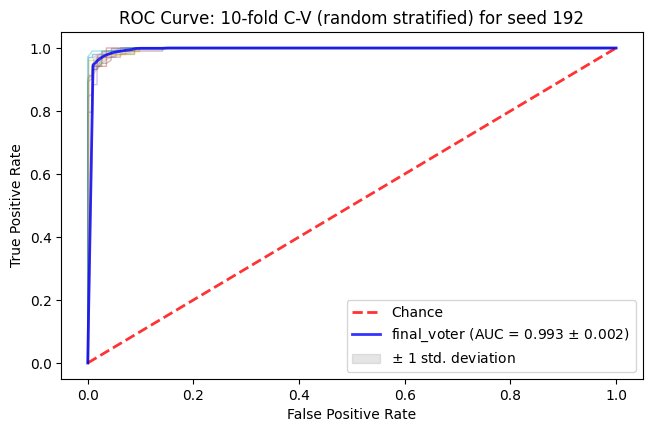

In [12]:
coastal_redwoods.validation_visuals(192, 193, 'test/outputs')

## Appendix 1: Feature Selection & EDA
---

Pre-processig feature selection using FSS with hyper-param optimized random forest using rankings from feature correlations to the target

In [13]:
import seaborn as sns

In [15]:
df = pd.read_csv('test/data/env_train/env_train_'+species_code+'_192.csv')
X = df.iloc[:,1:]
y = df['pa']

corr=[]
for i in range(0,19):
    corr.append(np.abs(np.corrcoef(X.iloc[:,i], y)[0,1]))
    
colnames = np.array(X.columns).tolist()
rankings = pd.Series(corr, index=colnames)
rankings.sort_values(axis=0, ascending=False, inplace=True)

In [16]:
df_meta = pd.read_csv('test/data/env_train/env_train_'+species_code+'_192_metadata.csv')
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161 entries, 0 to 2160
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pa       2161 non-null   int64  
 1   bclim1   2161 non-null   float64
 2   bclim10  2161 non-null   float64
 3   bclim11  2161 non-null   float64
 4   bclim12  2161 non-null   int64  
 5   bclim13  2161 non-null   int64  
 6   bclim14  2161 non-null   int64  
 7   bclim15  2161 non-null   float64
 8   bclim16  2161 non-null   int64  
 9   bclim17  2161 non-null   int64  
 10  bclim18  2161 non-null   int64  
 11  bclim19  2161 non-null   int64  
 12  bclim2   2161 non-null   float64
 13  bclim3   2161 non-null   float64
 14  bclim4   2161 non-null   float64
 15  bclim5   2161 non-null   float64
 16  bclim6   2161 non-null   float64
 17  bclim7   2161 non-null   float64
 18  bclim8   2161 non-null   float64
 19  bclim9   2161 non-null   float64
 20  lon      2161 non-null   float64
 21  lat      2161 

In [17]:
#HPO model fitting with rf classifier 
#block cv in R for cross vals as pre-processing

feature_names = ['bclim1', 'bclim10', 'bclim11', 'bclim12', 'bclim13', 'bclim14',
       'bclim15', 'bclim16', 'bclim17', 'bclim18', 'bclim19', 'bclim2',
       'bclim3', 'bclim4', 'bclim5', 'bclim6', 'bclim7', 'bclim8', 'bclim9']

X_train = df_meta[df_meta['fold']!=2][feature_names]
X_test = df_meta[df_meta['fold']==2][feature_names]
y_train = df_meta[df_meta['fold']!=2]['pa']
y_test = df_meta[df_meta['fold']==2]['pa']

n_estimators = [50, 57, 63, 68, 75]
max_features = [2,3,4]
min_samples_split= [2,3,4]
criterion=['gini']#, 'entropy']

tuned_parameters = {'criterion': criterion, 'max_features': max_features, 'min_samples_split': min_samples_split, 'n_estimators': n_estimators}

rf = RandomForestClassifier(random_state=43)

clf = GridSearchCV(rf, tuned_parameters, cv=10)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
      
tuned_rf = clf.best_estimator_
tuned_rf.fit(X_train, y_train)
y_true, y_pred = y_test, tuned_rf.predict(X_test)
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_true, y_pred))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=68,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)
Best parameters set found on development set:

{'criterion': 'gini', 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 68}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       193
           1       0.90      0.93      0.91       147

    accuracy                 

<Figure size 640x480 with 0 Axes>

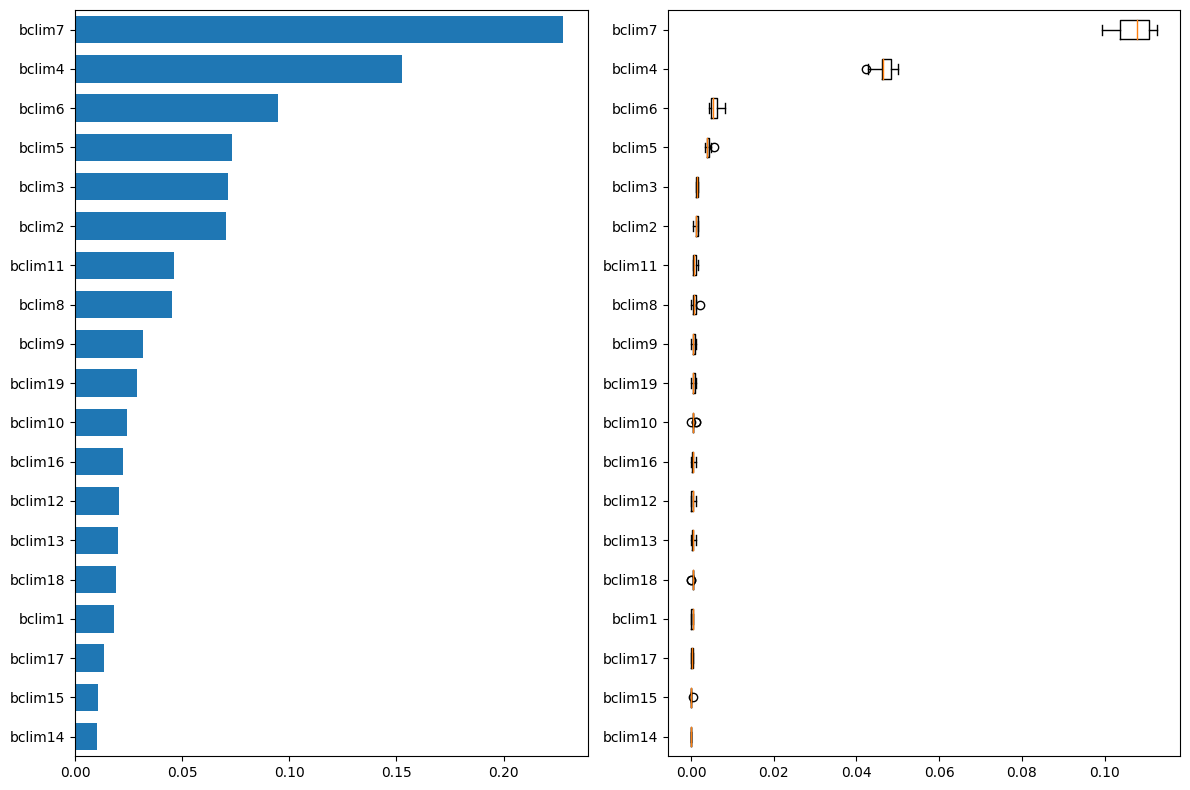

In [21]:
#perm importance scores from rf (right) and feature importances (left)
import matplotlib.pyplot as plt
plt.figure()
result = permutation_importance(tuned_rf, X_train, y_train, n_repeats=10,
                                random_state=43)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(tuned_rf.feature_importances_)
tree_indices = np.arange(0, len(tuned_rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         tuned_rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(tuned_rf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[tree_importance_sorted_idx])
fig.tight_layout()
plt.show()

X_train.columns[tree_importance_sorted_idx]
colnames_sorted = pd.Series(X_train.columns[tree_importance_sorted_idx])
ranking_permutation = colnames_sorted.iloc[::-1]

In [22]:
def feature_selector_targetcorr(rankings, tuned_rf):    
    feature_list = []
    scores = []

    #make sure to append until tuned_rf.max_features
    feature_list.append(rankings.index[0])
    feature_list.append(rankings.index[1])
    feature_list.append(rankings.index[2])
    
    rank_names = rankings.index[tuned_rf.max_features:]
    
    def feature_selector_FSS(rankings, tuned_rf, scores, feature_list, verbose=False):
        for feature in rank_names:
            feature_list.append(feature)
            tuned_rf_inner = tuned_rf        
            tuned_rf_inner.fit(X_train[feature_list], y_train)
            if verbose:
                print(feature_list)
                print(tuned_rf_inner.score(X_test[feature_list], y_test))
                print()

            scores.append(tuned_rf_inner.score(X_test[feature_list], y_test))
        
        scores_argmax = np.array(scores).argmax()
        return(scores, scores_argmax)
    
    #run the above function
    scores, scores_argmax  = feature_selector_FSS(rank_names, tuned_rf, scores, feature_list)
    #scores_argmax=10
    #find the best features with the argmax
    best_features = np.array(rankings.index[:scores_argmax+1+tuned_rf.max_features])
    return(scores, best_features)

scores, best_features = feature_selector_targetcorr(rankings, tuned_rf)

In [23]:
best_features

array(['bclim7', 'bclim4', 'bclim3', 'bclim2', 'bclim5', 'bclim6',
       'bclim11', 'bclim8', 'bclim9', 'bclim10', 'bclim15', 'bclim13',
       'bclim19', 'bclim16'], dtype=object)

In [24]:
tuned_rf.fit(X_train[best_features], y_train)
y_true, y_pred = y_test, tuned_rf.predict(X_test[best_features])
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_true, y_pred))

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       193
           1       0.90      0.93      0.91       147

    accuracy                           0.92       340
   macro avg       0.92      0.92      0.92       340
weighted avg       0.92      0.92      0.92       340



In [25]:
X_train[best_features]

,bclim7,bclim4,bclim3,bclim2,bclim5,bclim6,bclim11,bclim8,bclim9,bclim10,bclim15,bclim13,bclim19,bclim16
0,35.676003,768.484497,42.498222,15.161667,37.692001,2.016,8.172667,9.566000,26.638666,26.638666,79.359077,179,456,459
1,30.436001,597.131775,47.944321,14.592334,30.572001,0.136,4.840667,5.042667,19.167999,19.218000,74.002815,161,421,456
3,31.340000,603.445557,49.523506,15.520667,29.180000,-2.160,3.134667,3.618667,17.202667,17.633333,76.061882,183,508,532
4,22.220001,390.408020,55.744076,12.386333,26.864000,4.644,9.547334,9.547334,18.486668,19.112667,95.306374,228,610,610
5,26.643999,477.472809,52.190613,13.905666,28.320000,1.676,6.525333,6.982666,17.393333,18.049334,85.799065,303,843,870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,21.756001,348.872223,59.905312,13.033000,25.308001,3.552,8.938666,8.938666,16.852667,17.389999,92.679733,233,604,604
2157,37.360001,733.521545,47.183262,17.627666,33.716000,-3.644,3.088667,3.398000,20.740000,20.752666,65.089317,91,243,261
2158,24.952000,447.948364,53.458641,13.339000,29.320000,4.368,10.232667,11.047334,20.722668,21.127335,88.939140,95,244,248
2159,32.403999,621.362793,48.223473,15.626333,33.787998,1.384,7.739333,7.739333,22.571999,22.636000,93.549820,176,448,448


<Figure size 640x480 with 0 Axes>

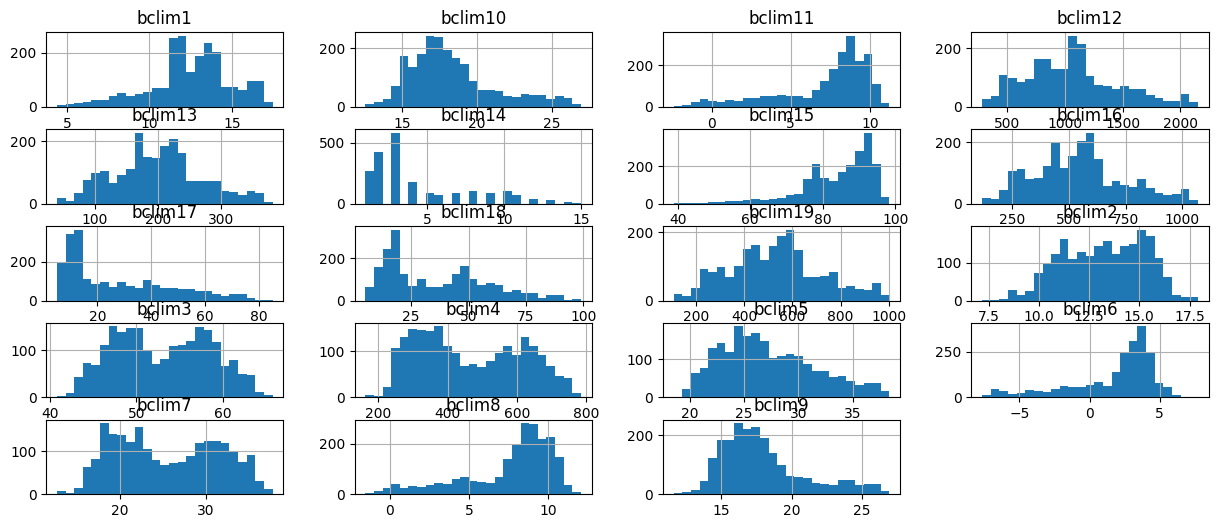

In [26]:
plt.figure()
X.hist(bins=25, figsize=(15, 6), layout=(5, 4))
plt.show()

<Figure size 640x480 with 0 Axes>

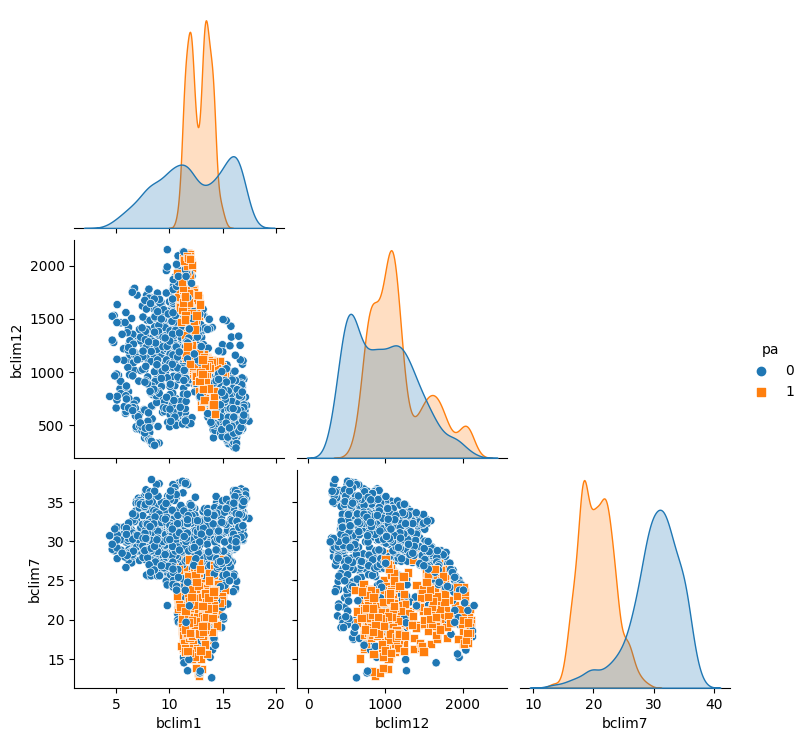

In [27]:
plt.figure()
sns.pairplot(df[["pa", "bclim1", "bclim12", "bclim7"]], hue="pa", markers=["o", "s"], corner=True)
plt.show()

In [28]:
print(np.mean(df[df['pa']==1][["bclim1", "bclim14", "bclim7"]]))
print()
print(np.mean(df[df['pa']==0][["bclim1", "bclim14", "bclim7"]]))

bclim1     12.804005
bclim14     3.641473
bclim7     20.520732
dtype: float64

bclim1     12.153230
bclim14     5.204606
bclim7     30.033738
dtype: float64


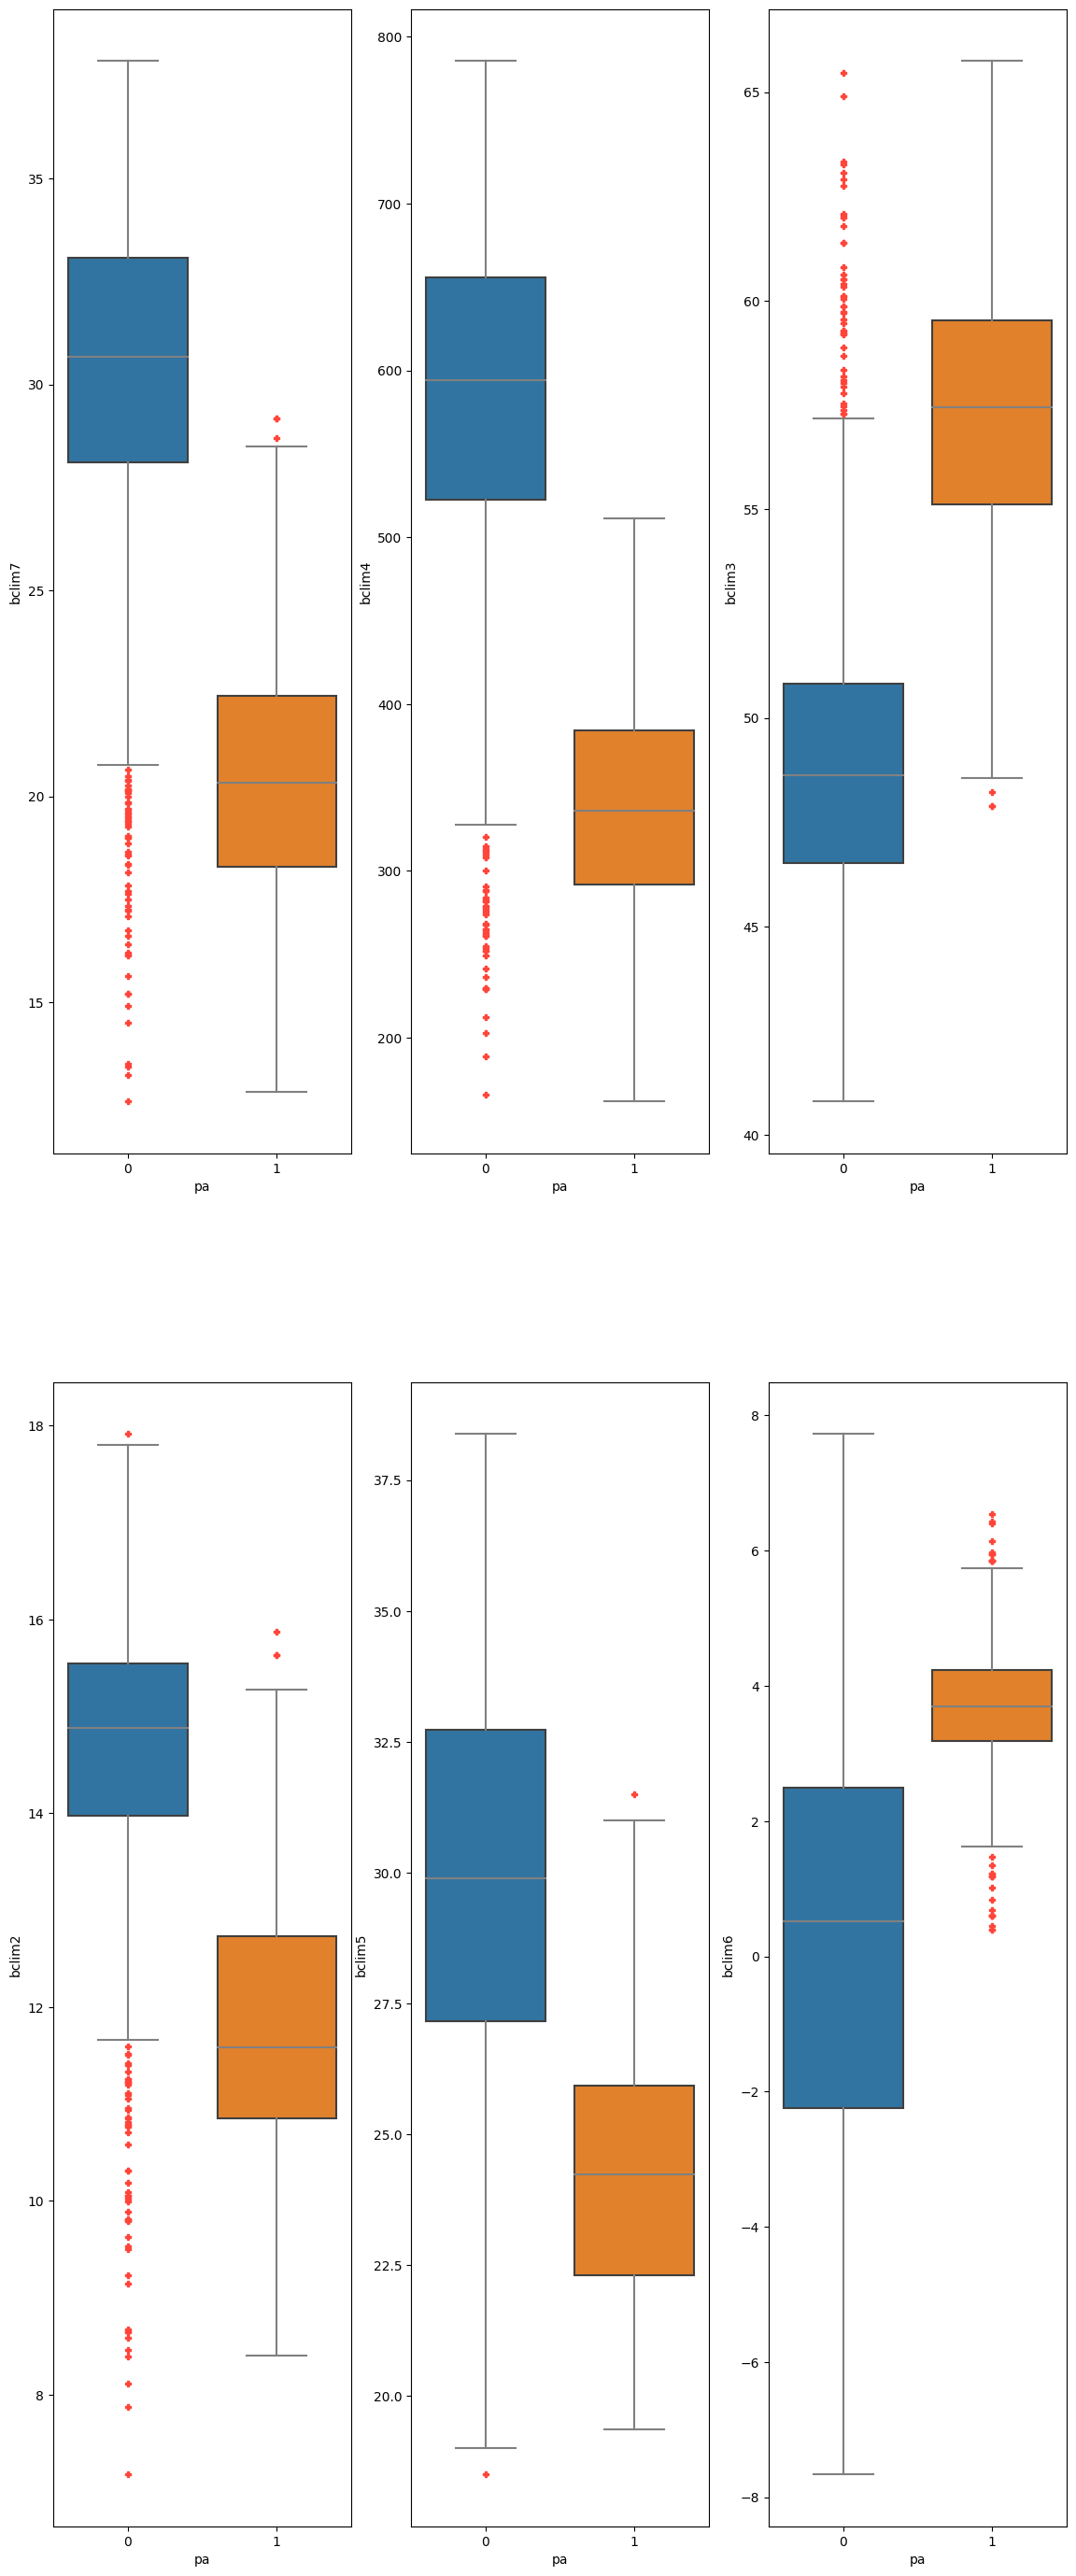

<Figure size 640x480 with 0 Axes>

In [31]:
#visualization of target vs feature ranked by correlation
numerical = np.array(rankings.index)
fig, ax = plt.subplots(2, 3, figsize=(14, 35))
red_square = dict(markerfacecolor=(1, 69/255, 58/255),markeredgecolor=(1, 69/255, 58/255),marker='P')
whisk = dict(color='grey')
cap = dict(color='grey')
median = dict(color='grey')

plt.figure()
for var, subplot in zip(numerical[0:6], ax.flatten()):
    sns.boxplot(x=df['pa'], y=var, data=df, ax=subplot, flierprops=red_square, medianprops=median, whiskerprops=whisk, capprops=cap)

plt.show()

## Citations
---

1. <a target="_blank" rel="noopener noreferrer" href="https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf">Species distribution modeling with R</a> (Hijmans and Elith, 2017)
2. Pyimpute's <a target="_blank" rel="noopener noreferrer" href="https://github.com/perrygeo/pyimpute/blob/master/README.md">README.md</a>
3. A study <a target="_blank" rel="noopener noreferrer" href="https://www.researchgate.net/publication/229149956_Selecting_Pseudo-Absences_for_Species_Distribution_Models_How_Where_and_How_Many">on generating pseudo absence points</a>  (Barbet-Massin et al., 2012)
4. A study <a target="_blank" rel="noopener noreferrer" href="https://www.nature.com/articles/s41598-018-25437-1
">on SDM transferability and pixel size</a>  (Manzoor et al., 2018)
5.  A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.13161">on SDMs for invasive species</a>  (Lake et al., 2020)
6. A book <a target="_blank" rel="noopener noreferrer" href="https://www.amazon.com/Mapping-Species-Distributions-Biodiversity-Conservation/dp/0521700027
">on mapping SDMs </a>  (Franklin, 2009)
7. A more modern <a target="_blank" rel="noopener noreferrer" href="https://damariszurell.github.io/SDM-Intro/"> SDMs tutorial</a> (Zurell, 2020) 
8. A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0587.2012.07348.x">on collinearity among model variables</a> (C. F. Dormann et al., 2012) 

## Data Citations
---

1. GBIF.org (01 November 2020) GBIF Occurrence Download https://doi.org/10.15468/dl.ceutzd 
2. Fick, S.E. and R.J. Hijmans, 2017. WorldClim 2: new 1km spatial resolution climate surfaces for global land areas. International Journal of Climatology 37 (12): 4302-4315.

